In [0]:
# setup environment
!pip install kappamodules

In [0]:
# check successful setup
import torch
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))

In [0]:
# clone repo
!git clone https://github.com/BenediktAlkin/upt-tutorial.git
%cd upt-tutorial

# 3 CIFAR10 Autoencoder

Now that we know how the core of UPT works, its time to introduce some of the new components.
In this notebook, we will change the last layer back to what UPT uses, i.e. a perceiver decoder.
To showcase this, we'll train a simple autoencoder by decoding the latent space of the model
via regular grid positions, i.e. we query the latent space with the positions of each pixel
to reconstruct the image from the latent space.

We'll keep the ViT patch embedding as first layer as we are working with images as input but
change the decoder back to the perceiver decoder.


<img width="60%" src="https://raw.githubusercontent.com/BenediktAlkin/upt-tutorial/main/schematics/upt_dense_autoencoder.svg">

Same dataloading as before except that we don't need the label here, because we train an autoencoder.

In [3]:
# initialize CIFAR10
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root="./data", train=True, download=True)

/system/apps/userenv/alkin/v3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


label: 6


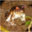

In [4]:
# visualize image
image, label = train_dataset[0]
print(f"label: {label}")
display(image)

The encoder is the same as in the previous tutorial (UPT with a ViT patch embedding instead of
the message passing to supernodes).

In [5]:
from upt.models.encoder_image import EncoderImage
encoder = EncoderImage(
    # CIFAR has 3 channels (RGB)
    input_dim=3,
    # CIFAR has 32x32 images -> patch_size=4 results in 64 patch tokens
    resolution=32,
    patch_size=4,
    # ViT-T latent dimension
    enc_dim=192,
    enc_num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    enc_depth=4,
    # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
    # perc_dim=dim,
    # perc_num_heads=num_heads,
    # num_latent_tokens=32,
)

# we can now encode images
image, label = train_dataset[0]
# convert image to a tensor
from torchvision.transforms import ToTensor
tensor = ToTensor()(image).unsqueeze(0)
encoded_image = encoder(tensor)
print(f"encoded_image.shape: {encoded_image.shape}")

encoded_image.shape: torch.Size([1, 64, 192])


In this setting, we dont really need an approximator, but we'll keep it for consistency.

In [6]:
from upt.models.approximator import Approximator
approximator = Approximator(
    # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
    input_dim=192,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)

approximator_output = approximator(encoded_image)
print(f"approximator_output.shape: {approximator_output.shape}")

approximator_output.shape: torch.Size([1, 64, 192])


We now need a decoder that can predict images, so we use the perceiver decoder and query
the latent space at each pixel position to produce an image.

In [7]:
from upt.models.decoder_perceiver import DecoderPerceiver
decoder = DecoderPerceiver(
    # tell the decoder the dimension of the input (dim of approximator)
    input_dim=192,
    # 3 channels for RGB
    output_dim=3,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
    # images are 2D
    ndim=2,
)

In [8]:
# to query the latent space, we need pixel positions (CIFAR10 has 32x32 pixels)
import einops
import torch
output_pos = einops.rearrange(
    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
    "ndim height width -> (height width) ndim",
)

In [9]:
# these positions are the pixel positions traversed row-wise from top-left
print(f"output_pos[0]: {output_pos[0]}")
print(f"output_pos[1]: {output_pos[1]}")
print(f"output_pos[2]: {output_pos[2]}")
print(f"output_pos[32]: {output_pos[32]}")
print(f"output_pos[1023]: {output_pos[1023]}")

output_pos[0]: tensor([0, 0])
output_pos[1]: tensor([0, 1])
output_pos[2]: tensor([0, 2])
output_pos[32]: tensor([1, 0])
output_pos[1023]: tensor([31, 31])


Lets decode an image!

In [10]:
# add batch dimension and convert to float
output_pos = output_pos.unsqueeze(0).float()

In [11]:
# decode
prediction = decoder(approximator_output, output_pos=output_pos)
print(f"prediction.shape: {prediction.shape}")

prediction.shape: torch.Size([1024, 3])


# Train a model
Now lets train the autoencoder.

In [14]:
import einops
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from tqdm import tqdm

from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_image import EncoderImage
from upt.models.upt_image_autoencoder import UPTImageAutoencoder

# initialize device
device = torch.device("cuda")

# initialize dataset
transform = ToTensor()
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

# hyperparameters
dim = 192  # ~6M parameter model
num_heads = 3
epochs = 10
batch_size = 256

# initialize model
model = UPTImageAutoencoder(
    encoder=EncoderImage(
        # CIFAR has 3 channels (RGB)
        input_dim=3,
        # CIFAR has 32x32 images -> patch_size=4 results in 64 patch tokens
        resolution=32,
        patch_size=4,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=4,
        # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
        # perc_dim=dim,
        # perc_num_heads=num_heads,
        # num_latent_tokens=32,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 3 channels for RGB
        output_dim=3,
        # images have 2D coordinates
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
        # reshape to image after decoding
        unbatch_mode="image",
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# output positions are fixed for training, we query on a regular grid
# CIFAR has 32x32 pixels
# output_pos will be a tensor of shape (32 * 32, 2) with and will contain x and y indices
# output_pos[0] = [0, 0]
# output_pos[1] = [0, 1]
# output_pos[2] = [0, 2]
# ...
# output_pos[32] = [1, 0]
# output_pos[1024] = [31, 31]
output_pos = einops.rearrange(
    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
    "ndim height width -> (height width) ndim",
)
output_pos = output_pos.to(device)
# convert output_pos from [0, 31] to [0, 1000] for better behavior with sin-cos pos embeddings
output_pos = output_pos / 31 * 1000
# decoder needs float dtype
output_pos = output_pos.float()

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? test_loss. ?????")
train_losses = []
test_losses = []
test_loss = float("inf")
loss = None
for _ in range(epochs):
    # train for an epoch
    for x, _ in train_dataloader:
        # prepare forward pass
        x = x.to(device)

        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        x_hat = model(x, output_pos=einops.repeat(output_pos, "... -> bs ...", bs=len(x)))
        loss = F.mse_loss(x_hat, x)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        update += 1
        pbar.update()
        pbar.set_description(
            f"train_loss: {loss.item():.4f} "
            f"test_loss: {test_loss:.4f} "
        )
        train_losses.append(loss.item())

    # evaluate
    test_loss = 0.
    for x, _ in test_dataloader:
        x = x.to(device)
        with torch.no_grad():
            x_hat = model(x, output_pos=einops.repeat(output_pos, "... -> bs ...", bs=len(x)))
        test_loss += F.mse_loss(x_hat, x, reduction="none").flatten(start_dim=1).mean(dim=1).sum().item()
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    pbar.set_description(
        f"train_loss: {loss.item():.4f} "
        f"test_loss: {test_loss:.4f} "
    )


Files already downloaded and verified
Files already downloaded and verified
parameters: 5.9M


train_loss: 0.0011 test_loss: 0.0011 : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1950/1950 [13:08<00:00,  2.87it/s]

Lets plot the learning curves!

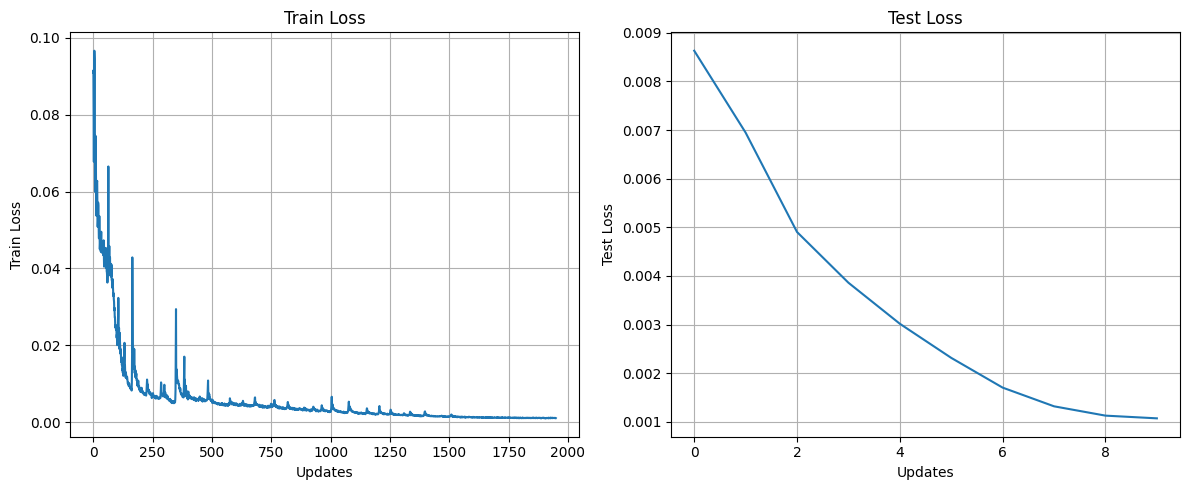

In [15]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].grid(True)
axes[1].plot(range(len(test_losses)), test_losses)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("Test Loss")
axes[1].grid(True)
plt.tight_layout()
plt.show()

Looks pretty good!
Lets also visualize a reconstruction:

In [16]:
x, _ = test_dataset[0]
x = x.to(device)
with torch.no_grad():
  x_hat = model(x.unsqueeze(0), output_pos=output_pos.unsqueeze(0)).squeeze(0)

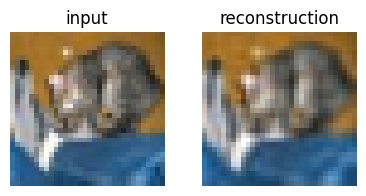

In [17]:
_, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(einops.rearrange(x.cpu(), "three height width -> height width three"))
axes[0].set_title("input")
axes[0].set_axis_off()
axes[1].imshow(einops.rearrange(x_hat.clamp(0, 1).cpu(), "three height width -> height width three"))
axes[1].set_title("reconstruction")
axes[1].set_axis_off()
plt.tight_layout()
plt.show()

Looks pretty good as well!